In [116]:
%load_ext autoreload
%autoreload 2
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import cmasher as cmr
cmap = cmr.dusk

from tqdm import tqdm
import joblib 

rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 8
rcParams['font.family'] = 'sans-serif'
%config InlineBackend.figure_format = "retina"

import sys
sys.path.append("/home/jdli/transpec")

import time
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from kvxp.xpformer import XPformer, XPformer2, CNN
from kvxp.data import  GXP_AP_4lb, GXP_5lb, GXP_4lb
from kvxp.utils import *
from kvxp.vis import draw_hist2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
device = torch.device('cuda:1')


data_dir = "/data/jdli/gaia/"
tr_file = "ap_xp_233985.npy"

gdata  = GXP_4lb(
    data_dir+tr_file, device=device,
    part_train=False,
)
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

gdf = pd.read_csv("/data/jdli/gaia/ap17_332904.csv")


In [127]:
def recover_scale_label(y_hat, e_y_hat,
                        scaler_name='../models/scaler_labels_0228.gz'):
    scaler_labels = joblib.load(scaler_name)
    y   = scaler_labels.inverse_transform(y_hat)
    e_y = e_y_hat * scaler_labels.scale_
    return y, e_y


def infer_4lbs_model(model, data_loader, transcale_method=recover_scale_label,
                     device=torch.device('cuda:0')):
    
    out_lst, e_out_lst = np.array([]), np.array([])
    id_lst = []

    with torch.no_grad():
        
        for data in tqdm(data_loader):
            
            x = data['x'][:,:n_xp]
            output = model(x, data['x_mask'])
            # output = model(x)
                
            out_lst   = np.append(out_lst,  output[:,:4].cpu().numpy())
            id_batch =  list(np.int64(data['id']))
            
            del output, data
            for idl in id_batch:
                id_lst.append(idl)

    out_lst = np.array(out_lst).reshape(-1,4)
    y, e_y = transcale_method(out_lst, out_lst)
    return {'labels':y, 'source_id':id_lst}


In [124]:
fold = 0
epoch = 500
# model_dir = "/data/jdli/gaia/model/0301_mpoor_pen/"
model_dir = "/data/jdli/gaia/model/0303_attn/"
save_point = f"sp2_4l_{fold}_ep{epoch}.pt"


n_enc = 11
n_outputs = 4
n_dim = 16
n_xp = 110

model = XPformer2(
    n_xp, n_outputs, 
    device=device, channels=n_dim
).to(device)

model.load_state_dict(remove_prefix(torch.load(model_dir+save_point)))


<All keys matched successfully>

In [128]:
pred_names   = ['teff', 'logg',  'moh', 'aom']
BATCH_SIZE = int(2**7)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)

        labels_infer = infer_4lbs_model(
            model, val_loader, 
            device=device, 
            transcale_method=recover_scale_label,
            # model_type=model_types[i],
            # cnn_idx=cnn_idxs[i], 
            # coef_mask=coef_masks[i]
        )

        rdf = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['source_id']], 
                           columns=pred_names+['source_id'])
        # rdfs = rdf if i==0 else pd.merge(rdfs, rdf, on='source_id')
        
print(rdf.shape)
rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", 
                     suffixes=(None, '_y'))
rdf_val.shape


FOLD 0
--------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:38<00:00,  9.44it/s]


(46797, 5)


(40126, 220)

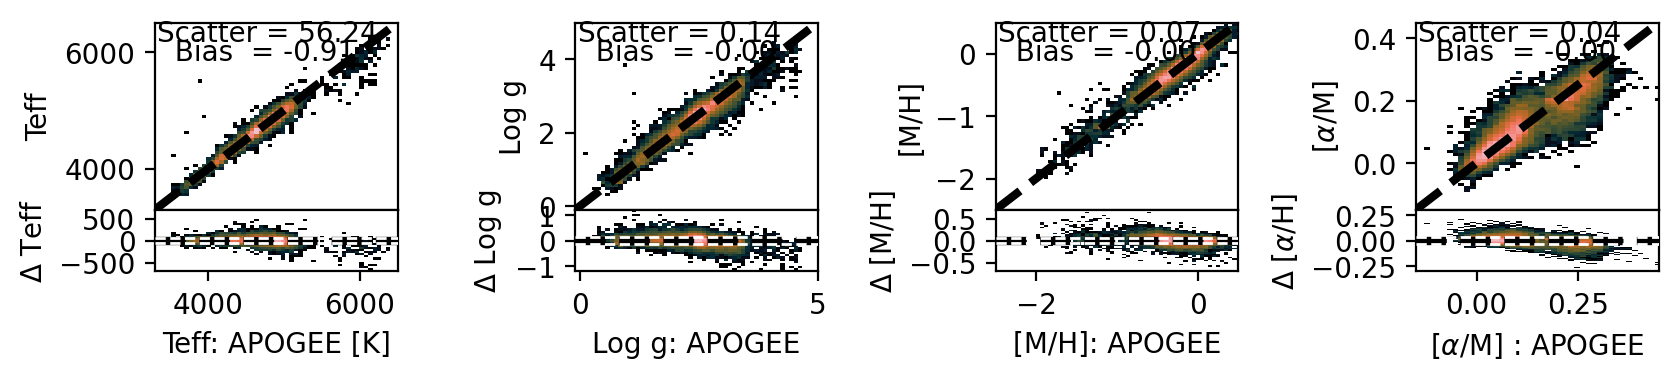

In [80]:
fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))

true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
# ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

    
for i in range(4):
    ynames = ['teff', 'logg', 'moh', 'aom']

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_val[true_names[i]], rdf_val[ynames[i]],
        xrange=xranges[i], bins=50,
        cmap='cmr.dusk'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

        
plt.tight_layout()

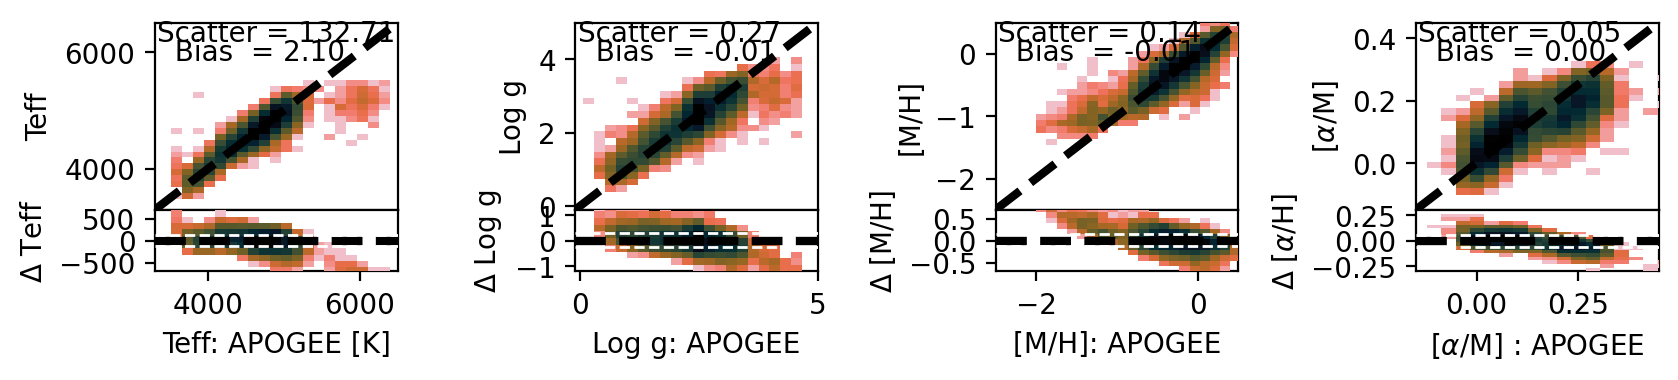

In [62]:
fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))

true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
# ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

    
for i in range(4):
    ynames = ['teff', 'logg', 'moh', 'aom']

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_val[true_names[i]], rdf_val[ynames[i]],
        xrange=xranges[i], bins=20,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

        
plt.tight_layout()

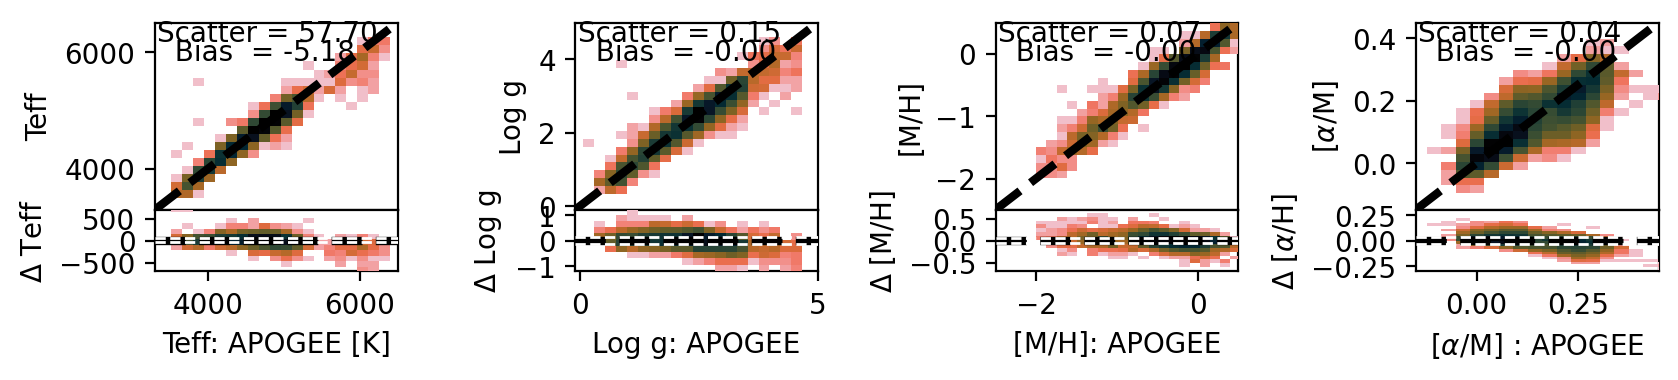

In [69]:
fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))

true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
# ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

    
for i in range(4):
    ynames = ['teff', 'logg', 'moh', 'aom']

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_val[true_names[i]], rdf_val[ynames[i]],
        xrange=xranges[i], bins=20,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

        
plt.tight_layout()

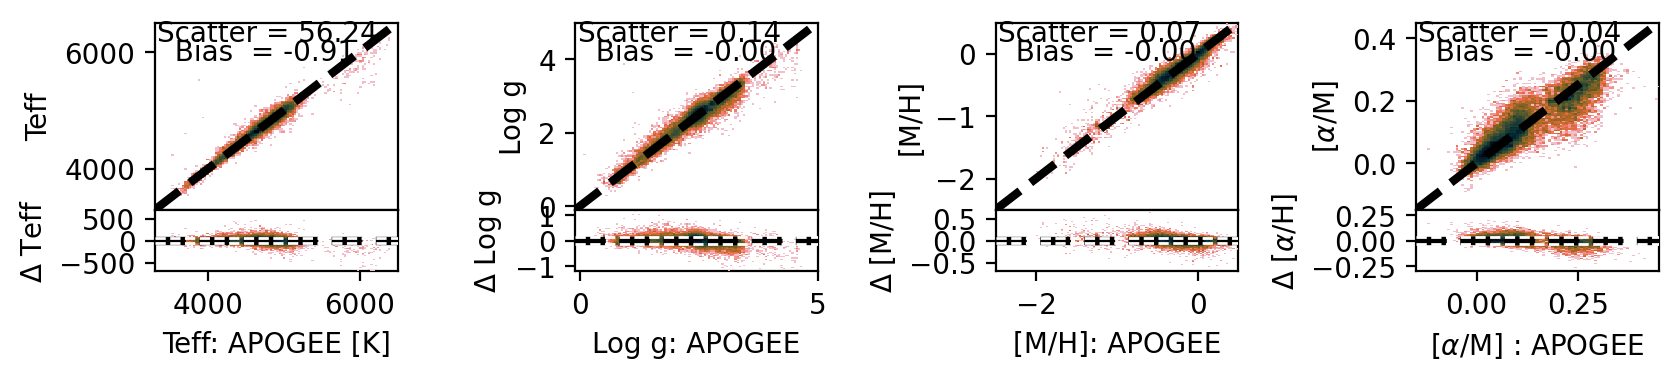

In [77]:
rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", 
                     suffixes=(None, '_y'))
fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))

true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
# ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

    
for i in range(4):
    ynames = ['teff', 'logg', 'moh', 'aom']

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_val[true_names[i]], rdf_val[ynames[i]],
        xrange=xranges[i], bins=100,
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

        
plt.tight_layout()

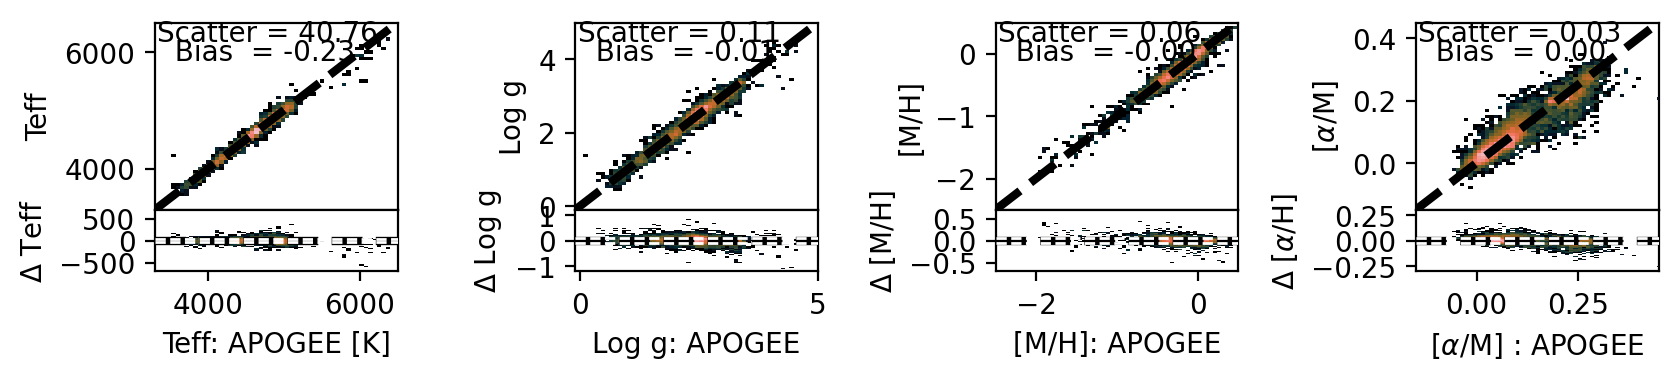

In [81]:
mask = rdf_val['GAIAEDR3_PHOT_G_MEAN_MAG']<12

fig, axs = plt.subplots(1,4, figsize=(8.5, 2*1))

true_names = ['TEFF', 'LOGG', 'M_H', 'ALPHA_M']

xranges = [[3300, 6500], [-0.1, 5], [-2.5, 0.5], [-0.15, 0.45]]
yranges = [[-700, 700],  [-1.2, 1.2],   [-0.7, 0.7], [-0.3, 0.3]]
xlabels = ['Teff: APOGEE [K]', 'Log g: APOGEE', '[M/H]: APOGEE', r"[$\alpha$/M] : APOGEE"]
# ylabels = ['Teff: XP [K]', 'Log g: XP', '[M/H]: XP', r"[$\alpha$/M] : XP"]
ylabels = ['Teff', 'Log g', '[M/H]', r'[$\alpha$/M]']
y2labels = [r'$\Delta$ Teff', r'$\Delta$ Log g', r'$\Delta$ [M/H]', r'$\Delta$ [$\alpha$/H]']

xticks  = [list(np.arange(4000, 7000, 500)), list(np.arange(1, 6, 1)), 
           list(np.arange(-2, 1, 0.5)),      list(np.arange(-0.2, 0.6, 0.2))]

    
for i in range(4):
    ynames = ['teff', 'logg', 'moh', 'aom']

    ax1, ax2 = draw_hist2d(
        axs[i], rdf_val[mask][true_names[i]], rdf_val[mask][ynames[i]],
        xrange=xranges[i], bins=50,
        cmap='cmr.dusk'
    )
    ax1.set_ylabel(ylabels[i]);
    ax1.set_xticks([]);
    ax2.set_xlabel(xlabels[i]);
    ax2.set_ylabel(y2labels[i]);
    ax2.set_ylim(yranges[i]);

        
plt.tight_layout()

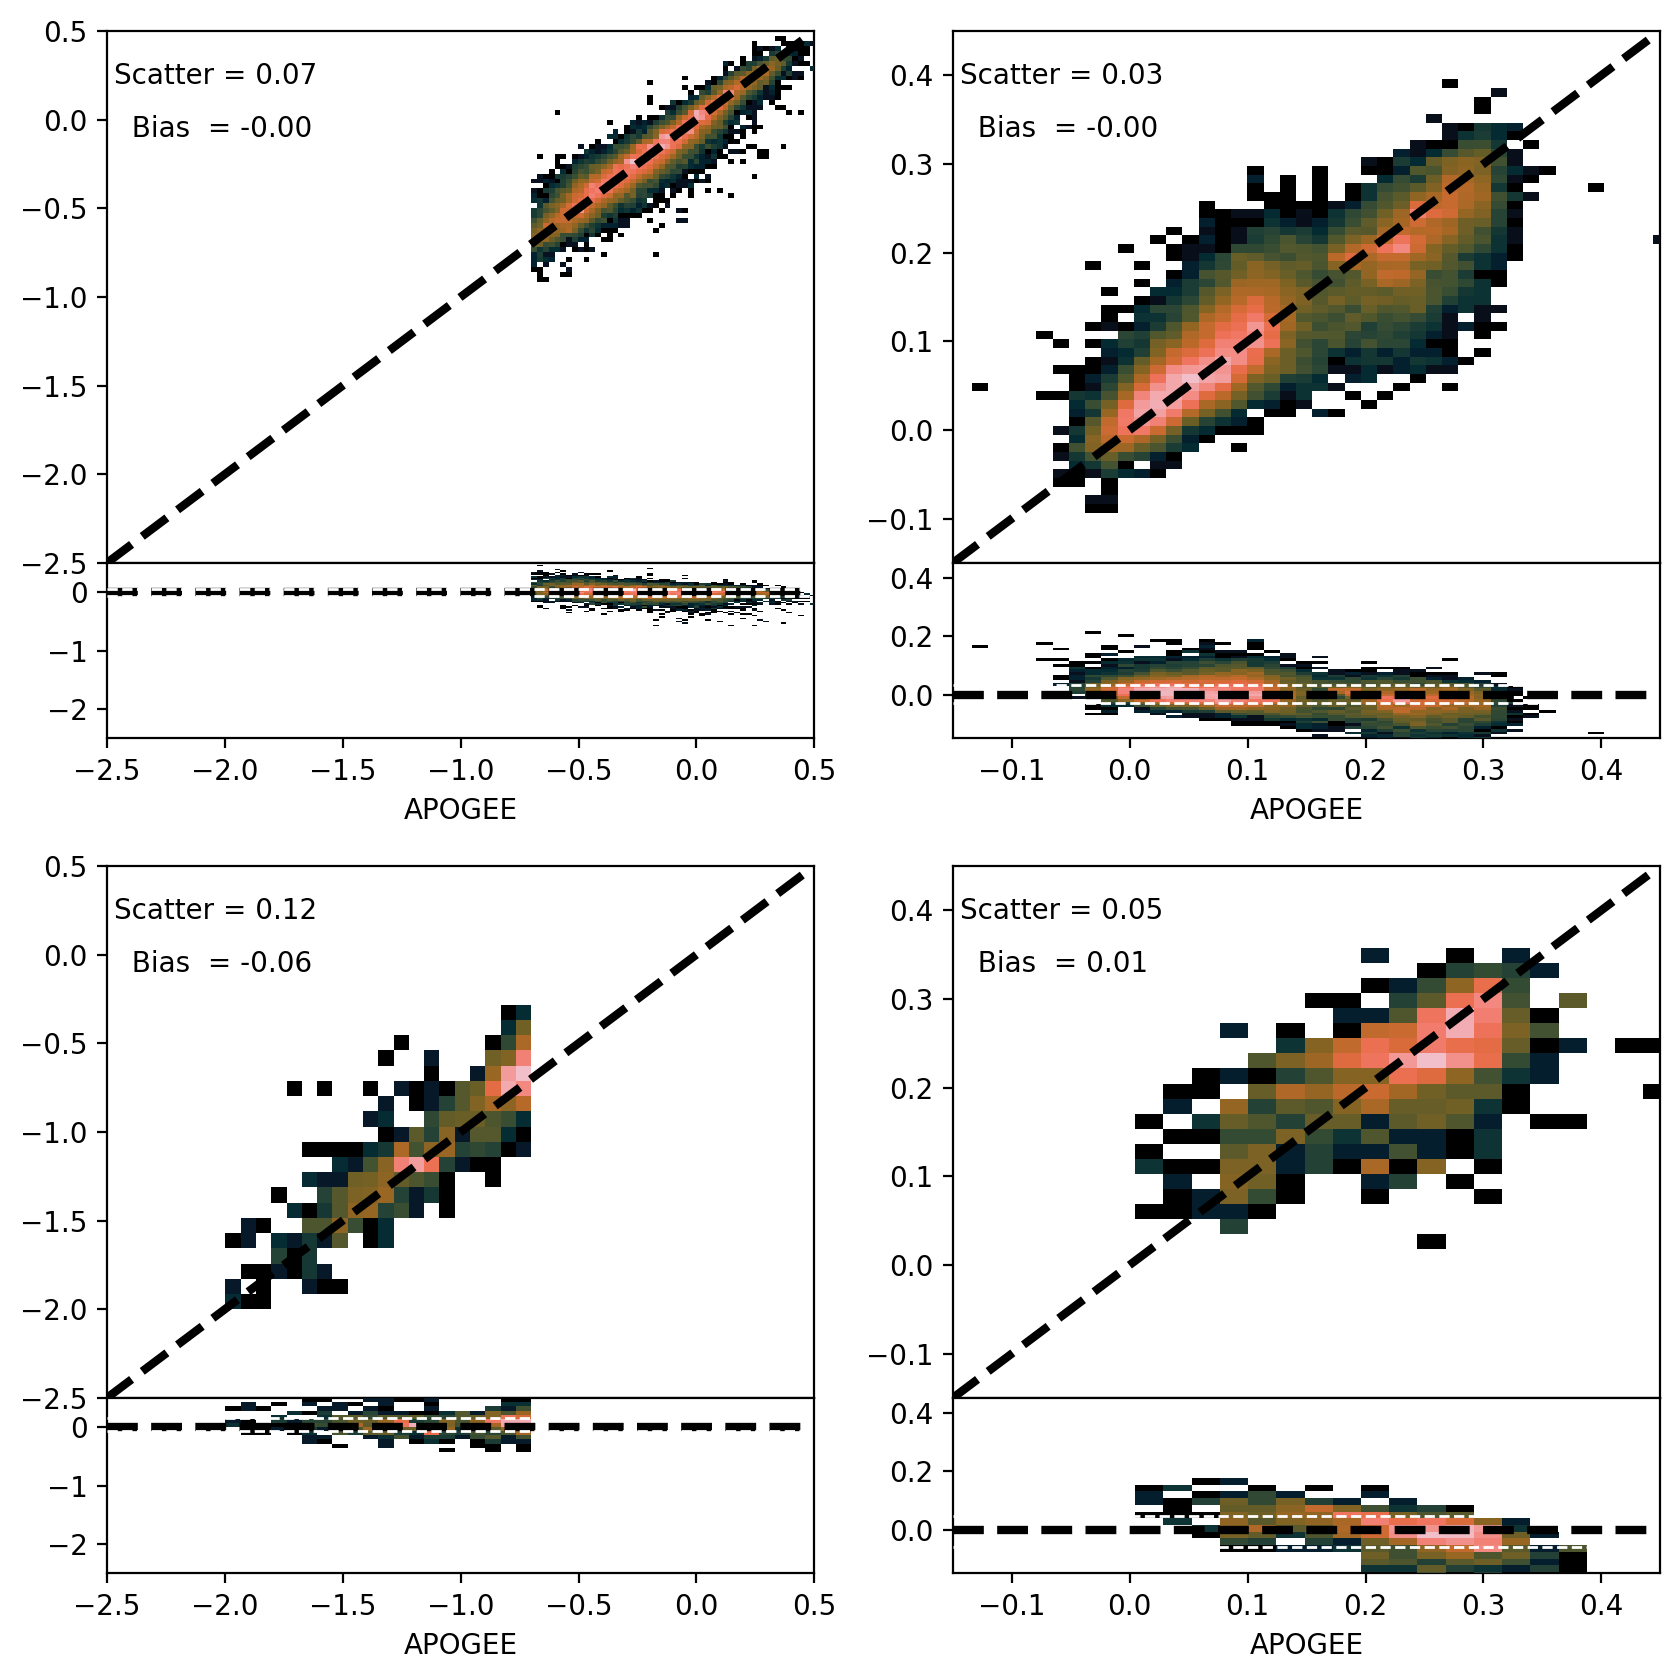

In [89]:
rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", 
                     suffixes=(None, '_y'))


mask_lst = [rdf_val['M_H']>-0.7,  rdf_val['M_H']<-0.7]
bin_sizes = [50, 20]

fig, axs = plt.subplots(2,2, figsize=(8.5, 8.5))

xranges = [[-2.5, 0.5], [-0.15, 0.45]]
true_names = ['M_H', 'ALPHA_M']
pred_names = ['moh', 'aom']
    
for j in range(2):
    
    for i in range(2):
        vdf = rdf_val[mask_lst[j]]

        ax1, ax2 = draw_hist2d(
            axs[j,i], vdf[true_names[i]], vdf[pred_names[i]],
            xrange=xranges[i], bins=bin_sizes[j],
            cmap='cmr.dusk'
        )
        
plt.tight_layout()

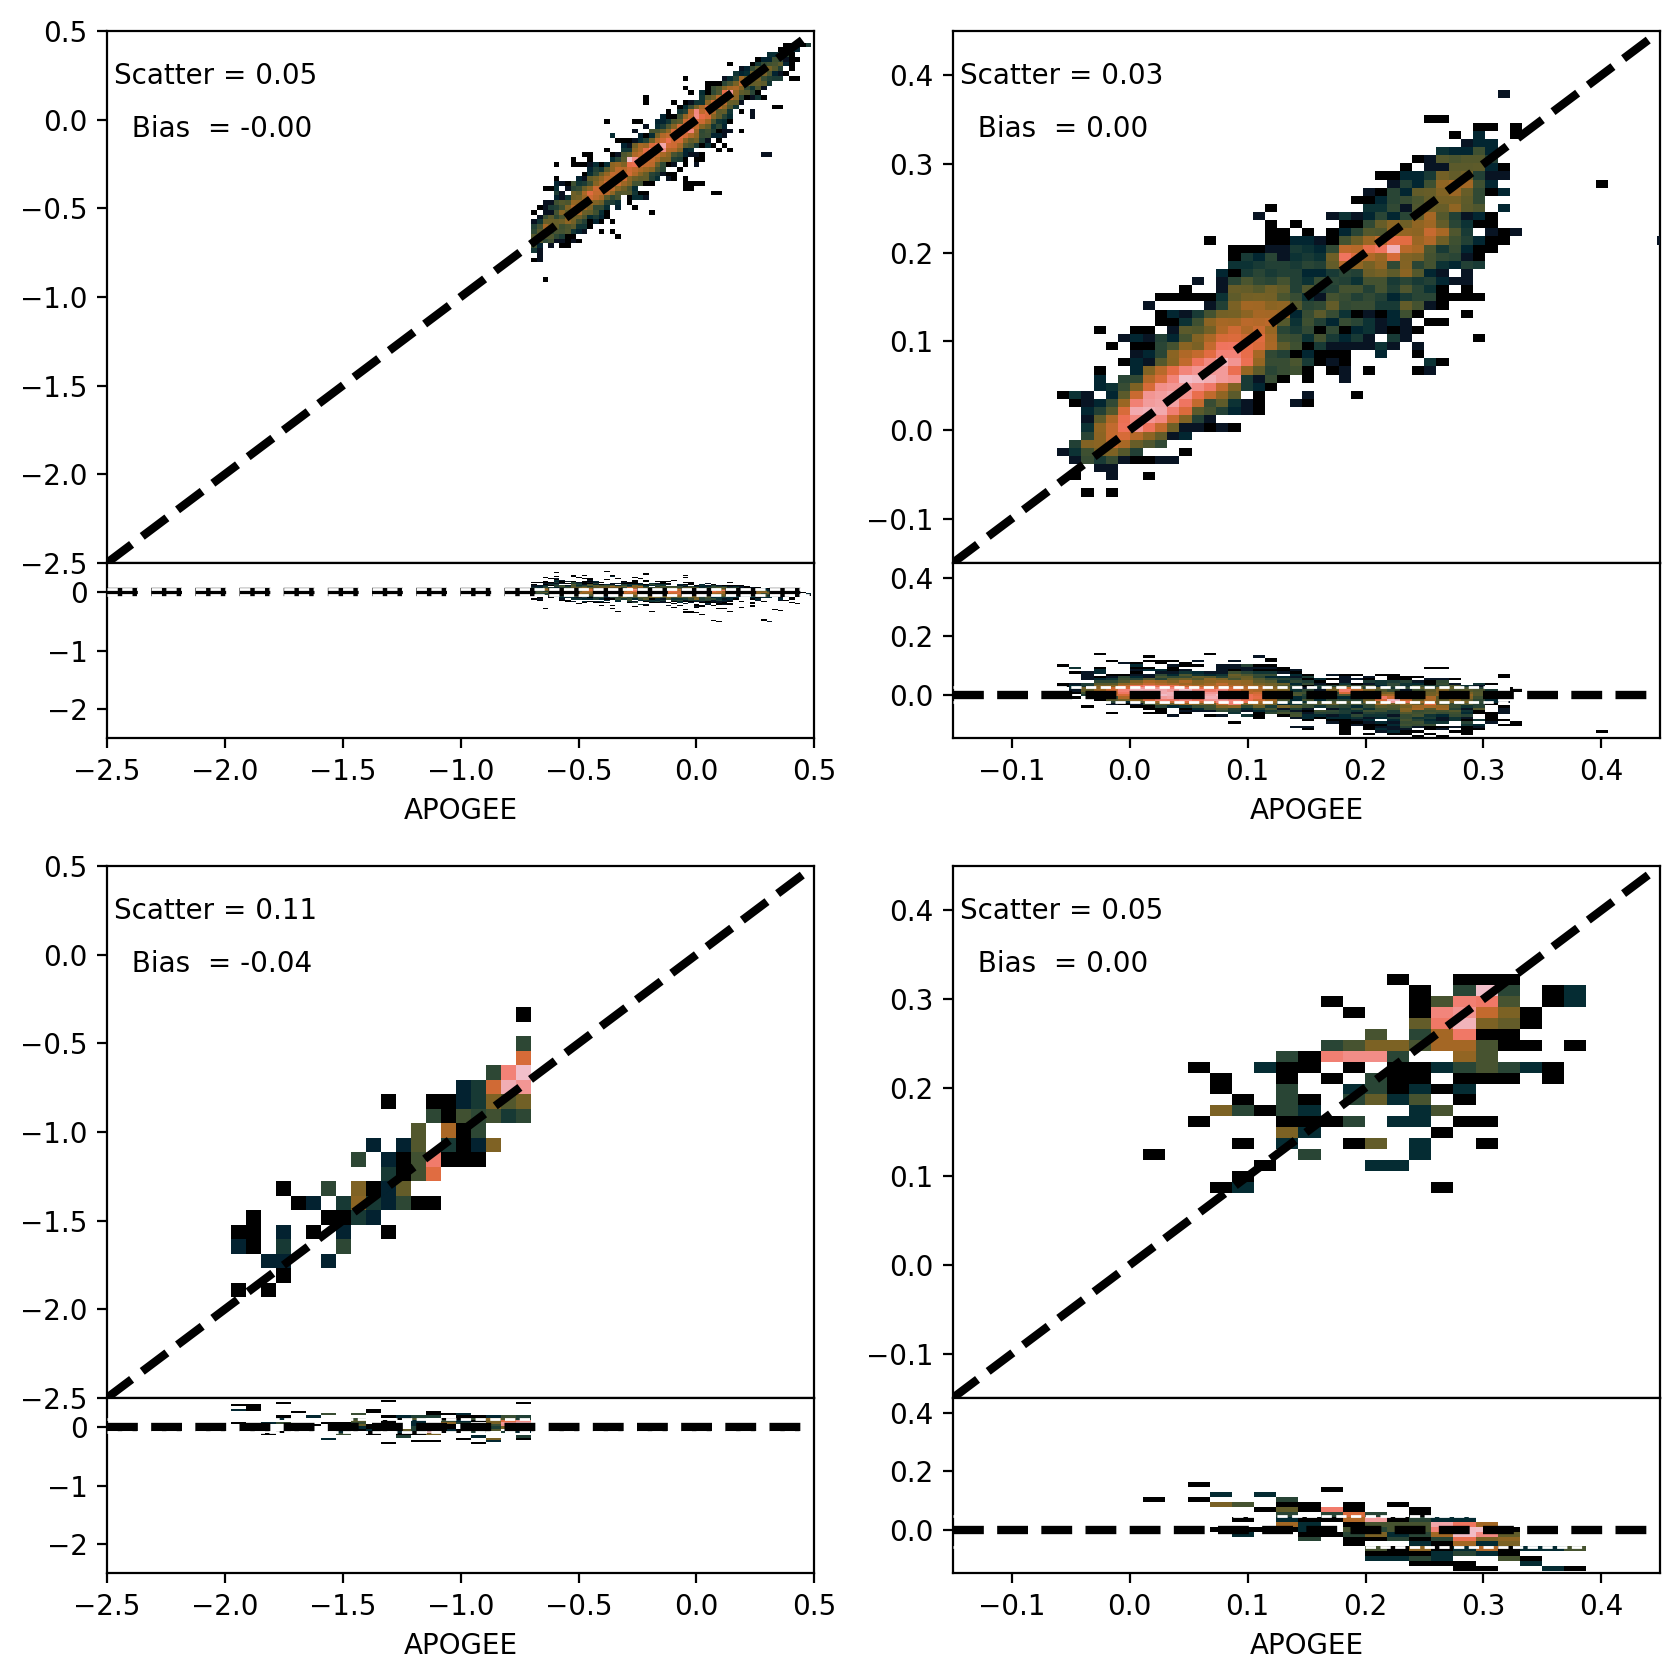

In [90]:
mask = rdf_val['GAIAEDR3_PHOT_G_MEAN_MAG']<12

rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", 
                     suffixes=(None, '_y'))


mask_lst = [(rdf_val['M_H']>-0.7) & mask,  
            (rdf_val['M_H']<-0.7) & mask]
bin_sizes = [50, 20]

fig, axs = plt.subplots(2,2, figsize=(8.5, 8.5))

xranges = [[-2.5, 0.5], [-0.15, 0.45]]
true_names = ['M_H', 'ALPHA_M']
pred_names = ['moh', 'aom']
    
for j in range(2):
    
    for i in range(2):
        vdf = rdf_val[mask_lst[j]]

        ax1, ax2 = draw_hist2d(
            axs[j,i], vdf[true_names[i]], vdf[pred_names[i]],
            xrange=xranges[i], bins=bin_sizes[j],
            cmap='cmr.dusk'
        )
        
plt.tight_layout()

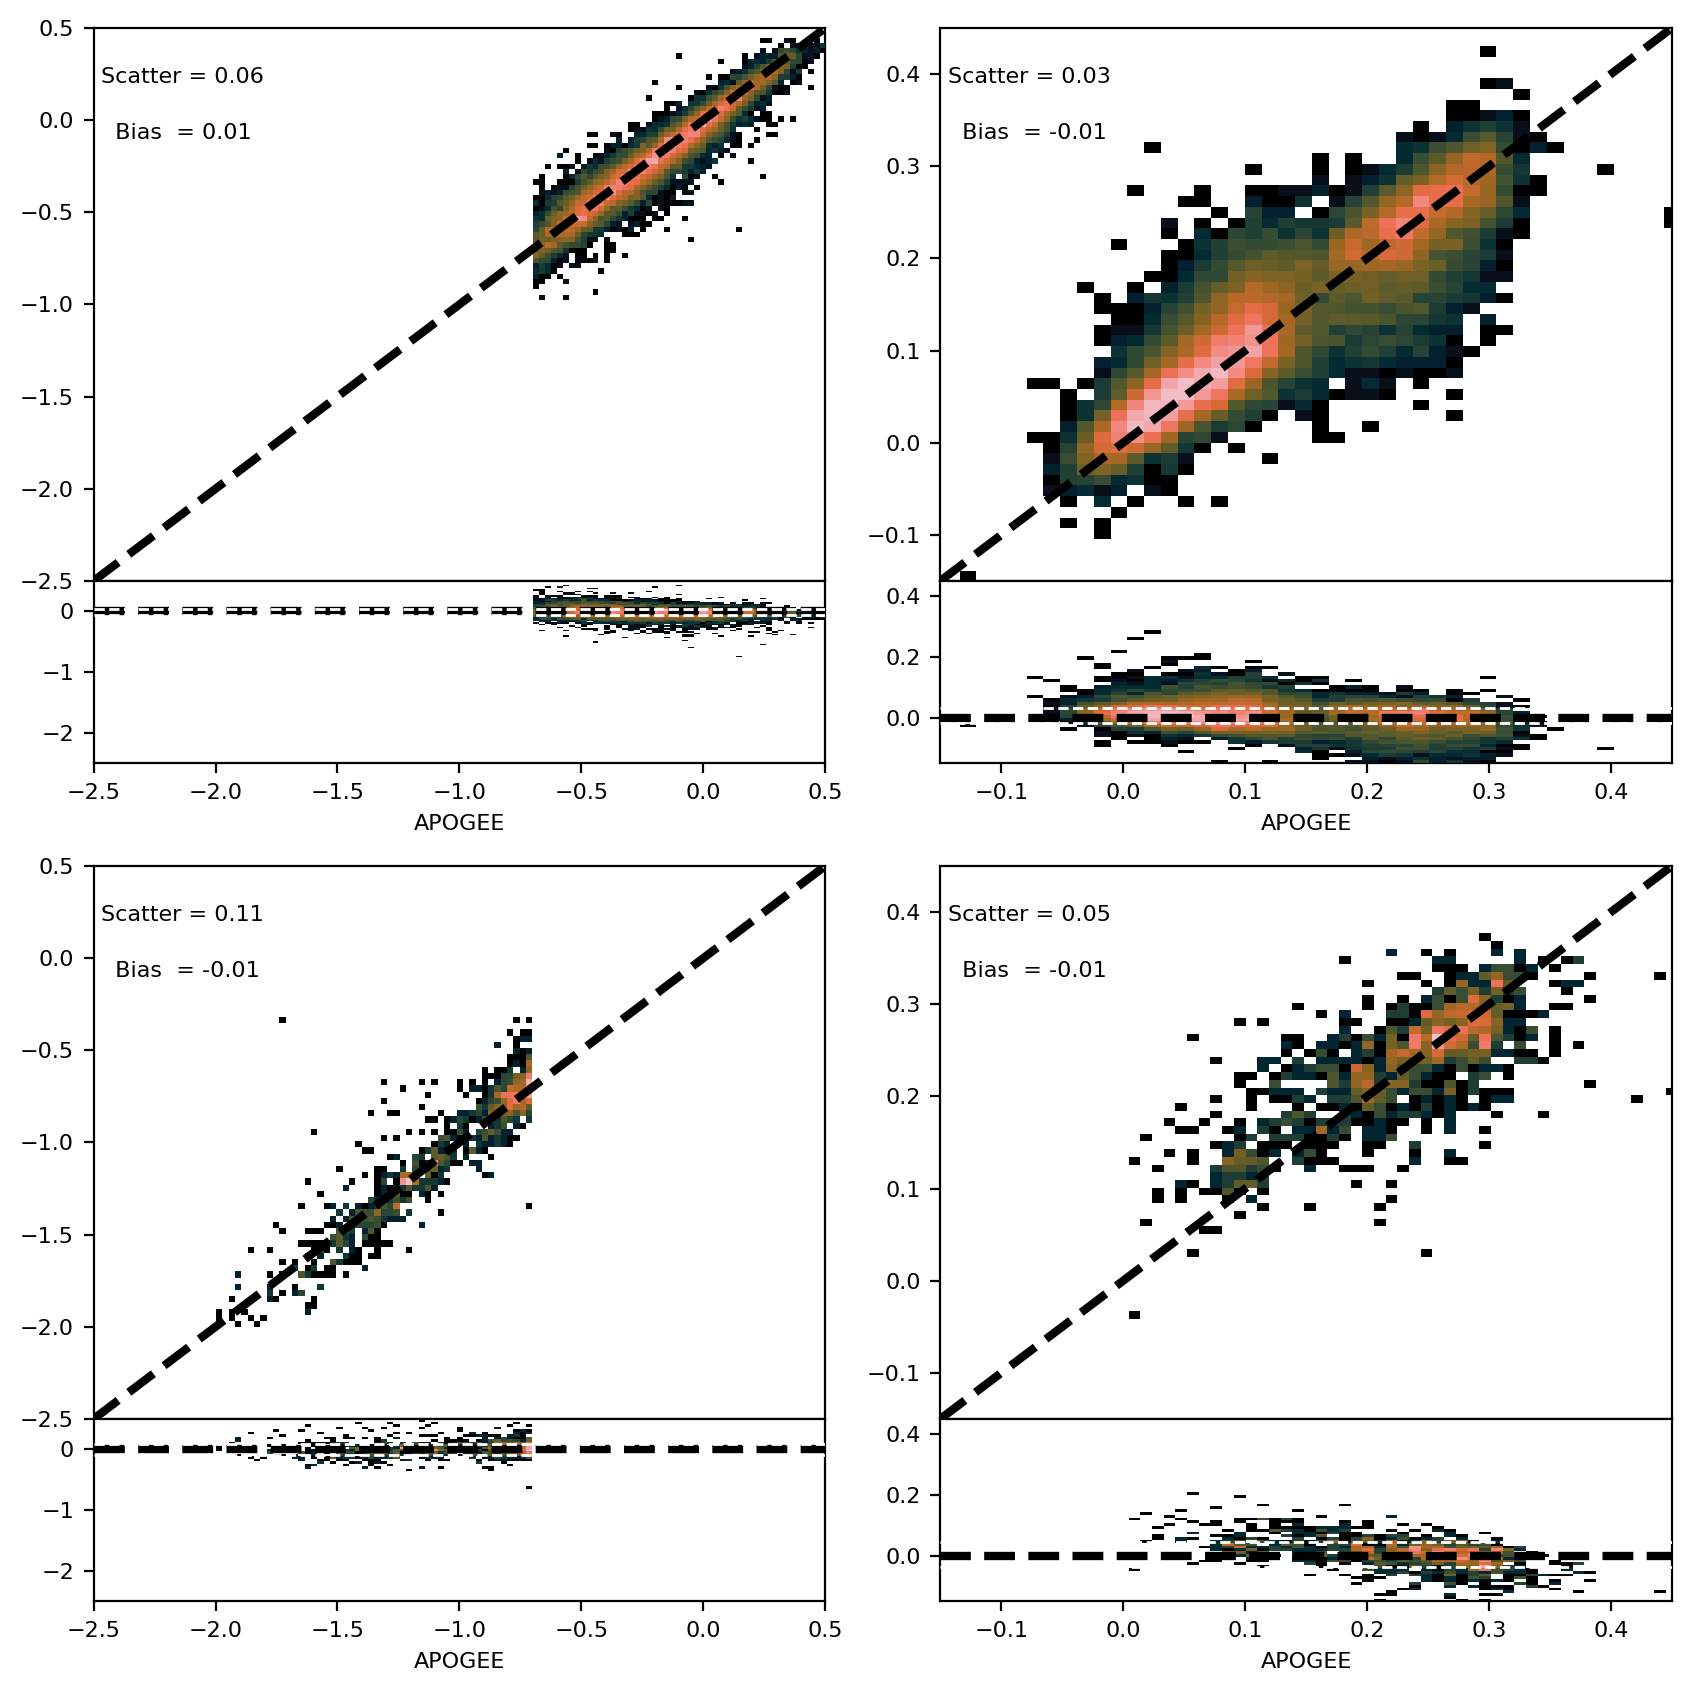

In [130]:
mask = rdf_val['GAIAEDR3_PHOT_G_MEAN_MAG']<25

# rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", 
#                      suffixes=(None, '_y'))

mask_lst = [(rdf_val['M_H']>-0.7) & mask,  
            (rdf_val['M_H']<-0.7) & mask]
bin_sizes = [50, 50]

fig, axs = plt.subplots(2,2, figsize=(8.5, 8.5))

xranges = [[-2.5, 0.5], [-0.15, 0.45]]
true_names = ['M_H', 'ALPHA_M']

pred_names = ['moh', 'aom']
    
for j in range(2):
    
    for i in range(2):
        vdf = rdf_val[mask_lst[j]]

        ax1, ax2 = draw_hist2d(
            axs[j,i], vdf[true_names[i]], vdf[pred_names[i]],
            xrange=xranges[i], bins=bin_sizes[j],
            cmap='cmr.dusk'
        )
        
plt.tight_layout()

# CNN baseline

In [118]:
fold = 0
epoch = 250
model_dir = "/data/jdli/gaia/model/0303_cnn/"
save_point = f"sp2_4l_{fold}_ep{epoch}.pt"


n_enc = 11
n_outputs = 4
n_dim = 8
n_xp = 110

model = CNN(
    n_xp, n_outputs, 
).to(device)

model.load_state_dict(remove_prefix(torch.load(model_dir+save_point)))


pred_names   = ['teff', 'logg',  'moh', 'aom']
BATCH_SIZE = int(2**7)

for fold, (train_ids, valid_ids) in enumerate(kfold.split(gdata)):
    
    if fold==0:
        
        print(f'FOLD {fold}')
        print('--------------------------------')

        valid_subsampler = SubsetRandomSampler(valid_ids)
        train_subsampler = SubsetRandomSampler(train_ids)
        val_loader   = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=valid_subsampler)
        tr_loader    = DataLoader(gdata, batch_size=BATCH_SIZE, sampler=train_subsampler)

        labels_infer = infer_4lbs_model(
            model, val_loader, 
            device=device, 
            transcale_method=recover_scale_label,
        )

        rdf = pd.DataFrame(np.c_[labels_infer['labels'], labels_infer['source_id']], 
                           columns=pred_names+['source_id'])
        
print(rdf.shape)
rdf_val = rdf.merge(gdf, left_on="source_id", right_on="GAIAEDR3_SOURCE_ID", 
                     suffixes=(None, '_y'))
rdf_val.shape


FOLD 0
--------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [00:25<00:00, 14.58it/s]


(46797, 5)


(40126, 220)

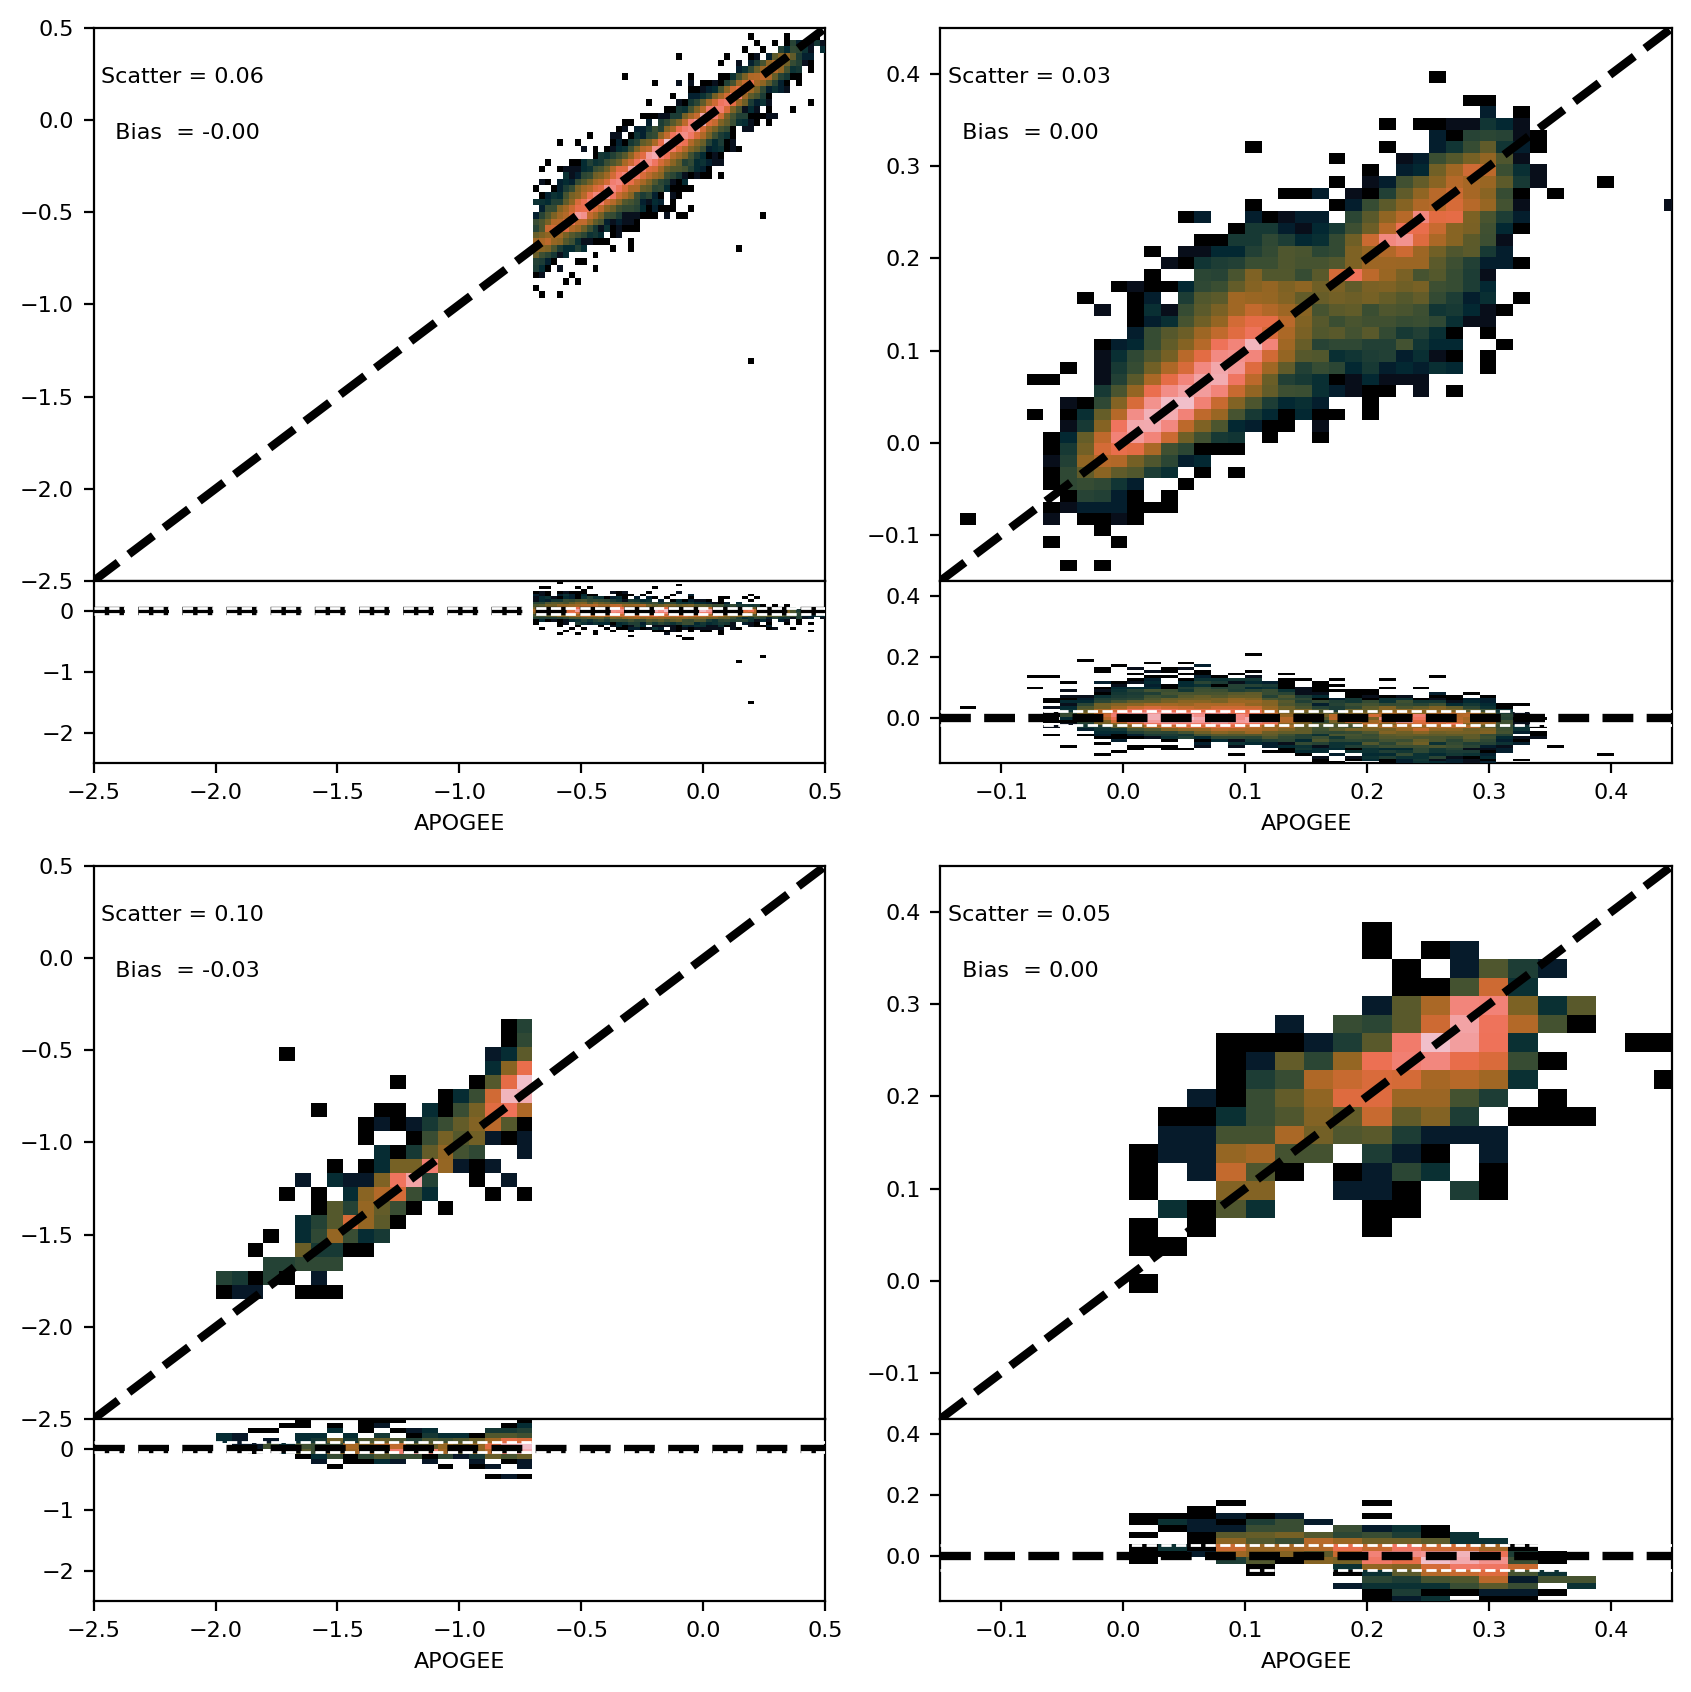

In [121]:
mask = rdf_val['GAIAEDR3_PHOT_G_MEAN_MAG']<25

mask_lst = [(rdf_val['M_H']>-0.7) & mask,  
            (rdf_val['M_H']<-0.7) & mask]
bin_sizes = [50, 20]

fig, axs = plt.subplots(2,2, figsize=(8.5, 8.5))

xranges = [[-2.5, 0.5], [-0.15, 0.45]]
true_names = ['M_H', 'ALPHA_M']
pred_names = ['moh', 'aom']
    
for j in range(2):
    
    for i in range(2):
        vdf = rdf_val[mask_lst[j]]

        ax1, ax2 = draw_hist2d(
            axs[j,i], vdf[true_names[i]], vdf[pred_names[i]],
            xrange=xranges[i], bins=bin_sizes[j],
            cmap='cmr.dusk'
        )
        
plt.tight_layout()